<font size="5">__cta-lstchain: Notebook for testing the effects of impact parameters on the energy reconstruction__</font>
    
<font size="4">
To run this notebook you will need the last version of cta-lstchain:

git clone https://github.com/cta-observatory/cta-lstchain
<br>
<br>
**If you have ctapipe already installed in a conda environment:**
<br><br>
source activate cta-dev
<br>
python setup.py install
<br>
<font size="4">
**If you don't have ctapipe installed:**</font>
<br><br>
conda env create -f environment.yml
<br>
source activate cta-dev
<br>
python setup.py install

Also, you will need the datafiles from **cta-lstchain-extra:**

git clone https://github.com/misabelber/cta-lstchain-extra

**Content:**
- Definition of two functions for presenting the energy resolution:
    - plot_e_resolution: For plotting the STD and Bias of Erec-Etrue in several energy bins.
    - calc_resolution: For calculating the overall energy resolution in terms of the 68% area.
- Plotting energy vs. intensity to check linearity.
- Training RF without cuts in Impact Parameter.
- Taining RF only with events with Impact Parameter between 40 m and 100 m.
- Training RF witg all events, but including Impact Parameter as a feature.



<font size="4">
**Some imports...**

In [2]:
import numpy as np                                                                                            
import pandas as pd                                                                                                                                                                                      
import matplotlib.pyplot as plt                                                                                                                                                             
from lstchain.reco import reco_dl1_to_dl2     
from lstchain.visualization import plot_dl2                                                                   
from lstchain.reco import utils
import scipy
from matplotlib import gridspec 
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 14

<font size="4">
**Define two functions to show results later**

In [3]:
def plot_e_resolution(data,Nbins):
    plt.rcParams['figure.figsize'] = (30, 10)
    plt.rcParams['font.size'] = 14

    #difE = ((data['mc_energy']-data['e_rec'])*np.log(10))
    difE = np.log(10**data['e_rec']/10**data['mc_energy'])
    means_result = scipy.stats.binned_statistic(                                                                                                        
            data['mc_energy'],[difE,difE**2],                                                                                                             
            bins=Nbins,range=(1,6),statistic='mean')                                                                                                           
    means, means2 = means_result.statistic                                                                                                              
    standard_deviations = np.sqrt(means2 - means**2)                                                                                                    
    bin_edges = means_result.bin_edges                                                                                                                  
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

    gs0 = gridspec.GridSpec(1,2,width_ratios=[1,2])
    subplot = plt.subplot(gs0[0])
    gs = gridspec.GridSpecFromSubplotSpec(2, 1,height_ratios=[1, 1],subplot_spec=subplot)

    ax0 = plt.subplot(gs[0])                                                                                                                            
    plot0 = ax0.errorbar(x=bin_centers, y=means, yerr=standard_deviations,linestyle='none', marker='.')

    plt.ylabel('Bias',fontsize=24)
    plt.grid()
    ax1 = plt.subplot(gs[1],sharex = ax0)                                                                                                              
    plot1 = ax1.plot(bin_centers,standard_deviations,                                                                                                   
                     marker='+',linestyle='None')
    plt.ylabel('STD',fontsize=24)
    plt.xlabel('$log_{10}E_{true}(GeV)$',fontsize=24)
    plt.grid()

    subplot2 = plt.subplot(gs0[1])
    
    #Lines for setting the configuration of the subplots depending on Nbins
    import math
    sqrtNbins = np.sqrt(Nbins)
    a = int(math.ceil(sqrtNbins))
    dif = a - sqrtNbins
    b=a
    if dif > 0.5:
        b=a-1
        
    gs2 = gridspec.GridSpecFromSubplotSpec(a, b,subplot_spec=subplot2)
    for nbin in range(0,Nbins):
        ax = plt.subplot(gs2[nbin])
        plt.hist(difE[means_result.binnumber==nbin+1],50,label='$logE_{center}$ '+'%.2f' % bin_centers[nbin])
        plt.legend()
    plt.subplots_adjust(hspace=.25)
    plt.subplots_adjust(wspace=.5)

In [4]:
def calc_resolution(data):
    difE = np.log(10**data['e_rec']/10**data['mc_energy'])
    n , bins, _ = plt.hist(difE,bins=500)
    mu,sigma = scipy.stats.norm.fit(difE)
    print(mu,sigma)
    bin_width = bins[1] - bins[0]
    total = bin_width*sum(n)*0.68
    idx = np.abs(bins - mu).argmin()
    x = 0
    mindif = 1e10
    xpos=0
    integral=0
    while integral <= total: 
        integral = bin_width*sum(n[idx-x:idx+x])
        x = x+1
    print(x,integral,total)
    sigma = bins[idx+x-1]
    plt.plot(bins,integral*scipy.stats.norm.pdf(bins, mu, sigma),linewidth=4,color='red',linestyle='--')
    plt.xlabel("$log(E_{rec}/E_{true})$")
    print(mu,sigma)
    return mu,sigma

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

<font size="4">
**Get event DL1 file for training.**
<br>
Gammas are pointlike.

In [6]:
try:
    PATH_EVENTS = "/home/queenmab/DATA/LST1/Events"
    gammafile = PATH_EVENTS+"/gamma_events_point.h5"
    df_gammas = pd.read_hdf(gammafile) 
    
except:
    PATH_EVENTS = "../../cta-lstchain-extra/reco/sample_data/dl1/"
    gammafile = PATH_EVENTS+"/gamma_events_point_tiny.h5"
    df_gammas = pd.read_hdf(gammafile) 

<font size="4">
We read the file as pandas dataframes:

In [7]:
df_gammas.keys()

Index(['obs_id', 'event_id', 'mc_energy', 'mc_alt', 'mc_az', 'mc_core_x',
       'mc_core_y', 'mc_h_first_int', 'mc_type', 'gps_time', 'width', 'length',
       'wl', 'phi', 'psi', 'r', 'x', 'y', 'intensity', 'skewness', 'kurtosis',
       'mc_alt_tel', 'mc_az_tel', 'impact', 'mc_x_max', 'time_gradient',
       'intercept', 'src_x', 'src_y', 'disp', 'hadroness'],
      dtype='object')

<font size="4">
We can keep only bright showers:

In [12]:
df_gammas = df_gammas[df_gammas['intensity']>np.log10(300)]
df_gammas.describe()

,obs_id,event_id,mc_energy,mc_alt,mc_az,mc_core_x,mc_core_y,mc_h_first_int,mc_type,gps_time,...,mc_alt_tel,mc_az_tel,impact,mc_x_max,time_gradient,intercept,src_x,src_y,disp,hadroness
count,121810.000000,1.218100e+05,121810.000000,121810.00000,121810.000000,121810.000000,121810.000000,121810.000000,121810.0,1.218100e+05,...,121810.00000,121810.0,121810.000000,121810.000000,121810.000000,121810.000000,1.218100e+05,1.218100e+05,121810.000000,121810.0
mean,11030.064740,5.000500e+06,2.558007,1.22173,6.283185,-89.019809,-7.773842,25108.073161,0.0,1.445304e+09,...,1.22173,0.0,187.085380,284.780543,-0.036436,8.014762,4.103384e-13,-2.892042e-06,0.565852,0.0
std,657.733032,2.889776e+06,0.573633,0.00000,0.000000,140.030741,152.321708,8323.509569,0.0,1.215790e+05,...,0.00000,0.0,90.384937,67.084637,11.041849,3.677542,2.019492e-28,1.270555e-21,0.238050,0.0
min,10147.000000,3.030000e+02,0.837788,1.22173,6.283185,-1134.100586,-599.204346,5730.250000,0.0,1.445077e+09,...,1.22173,0.0,0.378799,-20.000000,-75.114238,-34.812236,4.103384e-13,-2.892042e-06,0.003186,0.0
25%,10386.000000,2.493703e+06,2.139048,1.22173,6.283185,-190.212273,-114.304245,19374.996582,0.0,1.445191e+09,...,1.22173,0.0,119.994959,238.768322,-7.149829,6.453567,4.103384e-13,-2.892042e-06,0.373127,0.0
50%,11495.000000,4.998758e+06,2.457045,1.22173,6.283185,-89.630074,-8.003608,23638.800781,0.0,1.445334e+09,...,1.22173,0.0,174.980100,277.500000,-0.040279,9.064687,4.103384e-13,-2.892042e-06,0.547137,0.0
75%,11680.000000,7.500252e+06,2.868242,1.22173,6.283185,11.036971,99.007421,29148.908203,0.0,1.445409e+09,...,1.22173,0.0,247.097679,321.559631,7.051422,10.487890,4.103384e-13,-2.892042e-06,0.770790,0.0
max,11715.000000,1.000001e+07,5.488329,1.22173,6.283185,724.754822,752.423767,102674.273438,0.0,1.445554e+09,...,1.22173,0.0,1081.033976,775.039368,82.991954,23.041262,4.103384e-13,-2.892042e-06,1.123339,0.0


<font size="4">
Energy should be proportional to intensity:

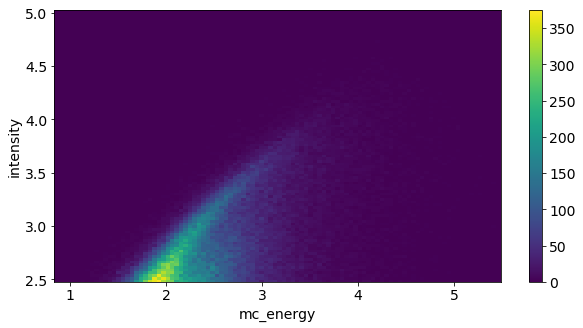

In [18]:
h = plt.hist2d(df_gammas['mc_energy'],df_gammas['intensity'],bins=100)
plt.xlabel('mc_energy')
plt.ylabel('intensity')
plt.colorbar(h[3])

<font size="4">
Let's choose events with a closer impact parameter (>40m, <100m)

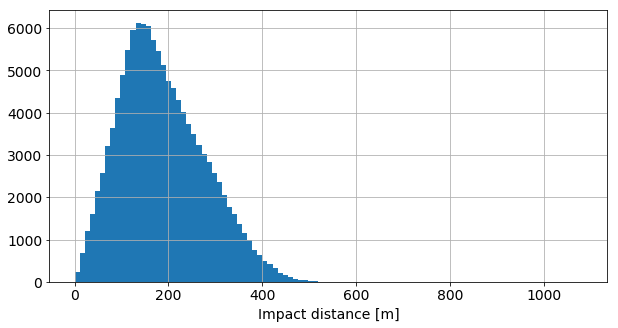

In [24]:
df_gammas['mc_core_distance'] = df_gammas['impact'] #Uncomment if you are using an old file without the "mc_core_distance key"
df_gammas['disp_norm'] = df_gammas['disp'] #Uncomment if you are using old files withot disp norm
df_gammas.mc_core_distance.hist(bins=100);
plt.xlabel('Impact distance [m]');

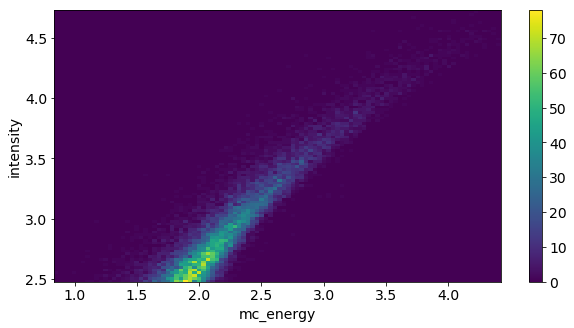

In [20]:
filter_impact = (df_gammas.mc_core_distance > 40) & (df_gammas.mc_core_distance < 100)
closer = df_gammas[filter_impact]
c = plt.hist2d(closer['mc_energy'],closer['intensity'],bins=100)
plt.xlabel('mc_energy')
plt.ylabel('intensity')
plt.colorbar(c[3]);

<font size="4">
Correlation is much more clear for this range. 
<br><br>
Let's see how this cut affect to the energy reconstruction.
<br><br>
First of all, let's train a Random Forest with all events, **without any cut** and without using any mc information.
<br>
Choose the features for training the random forest (Hillas and Timing parameters) 

In [21]:
features = ['intensity',                                                                                  
            'time_gradient',                                                                              
            'width',                                                                                      
            'length',                                                                                     
            'wl',                                                                                         
            'phi',                                                                                        
            'psi',
            'skewness',
            'kurtosis']

<font size="4">
Split data into train and test sets.

In [25]:
np.random.seed(0)
train, test = reco_dl1_to_dl2.split_traintest(df_gammas, 0.8)
print("Training datasets: {} events \nTest dataset: {} events".format(len(train), len(test)))

Training datasets: 97448 events 
Test dataset: 24362 events


/home/queenmab/anaconda3/envs/cta-dev/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<font size="4">
And train Random Forests for Energy and Disp reconstruction.

In [26]:
RFreg_Energy, RFreg_Disp = reco_dl1_to_dl2.trainRFreco(train,features)

Given features:  ['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi', 'skewness', 'kurtosis']
Number of events for training:  97448
Training Random Forest Regressor for Energy Reconstruction...
Random Forest trained!
Training Random Forest Regressor for disp_norm Reconstruction...
Random Forest trained!
Done!


<font size="4">
Apply RF to test data to reconstruct Energy.

Feature importances (gini index)
1. intensity (0.447086)
2. skewness (0.273213)
3. time_gradient (0.144951)
4. length (0.074358)
5. kurtosis (0.023839)
6. wl (0.015911)
7. width (0.011474)
8. psi (0.007250)
9. phi (0.001918)


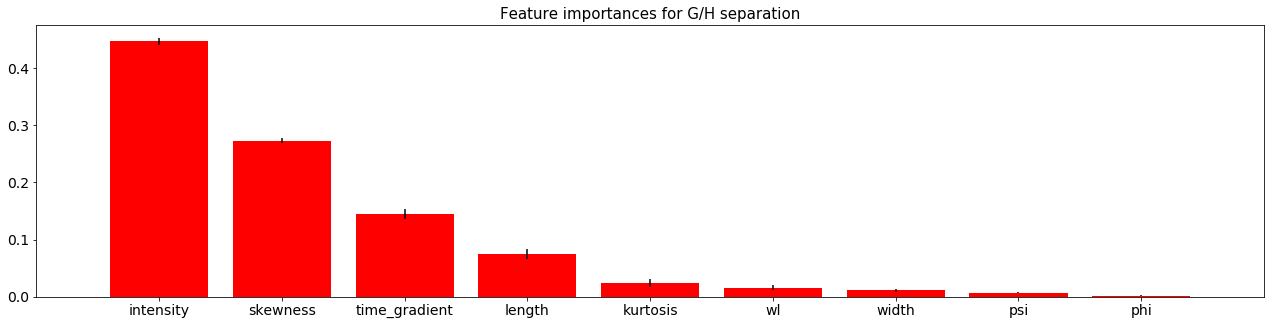

In [27]:
from lstchain.visualization.plot_dl2 import plot_importances
plt.figure(figsize=(22,5))
plot_importances(RFreg_Energy, features);

In [28]:
test['e_rec'] = RFreg_Energy.predict(test[features])

/home/queenmab/anaconda3/envs/cta-dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


-0.002175666477382578 0.5881971565629667
20 372.05075345663636 370.2662687662616
-0.002175666477382578 0.4268663273162536


(-0.002175666477382578, 0.4268663273162536)

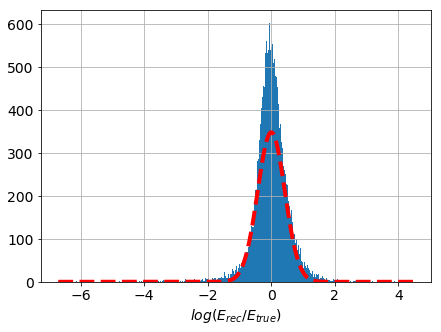

In [29]:
plt.figure(figsize=(7,5))
plt.grid()
#plot_dl2.plot_e(test,True)
calc_resolution(test)

/home/queenmab/anaconda3/envs/cta-dev/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


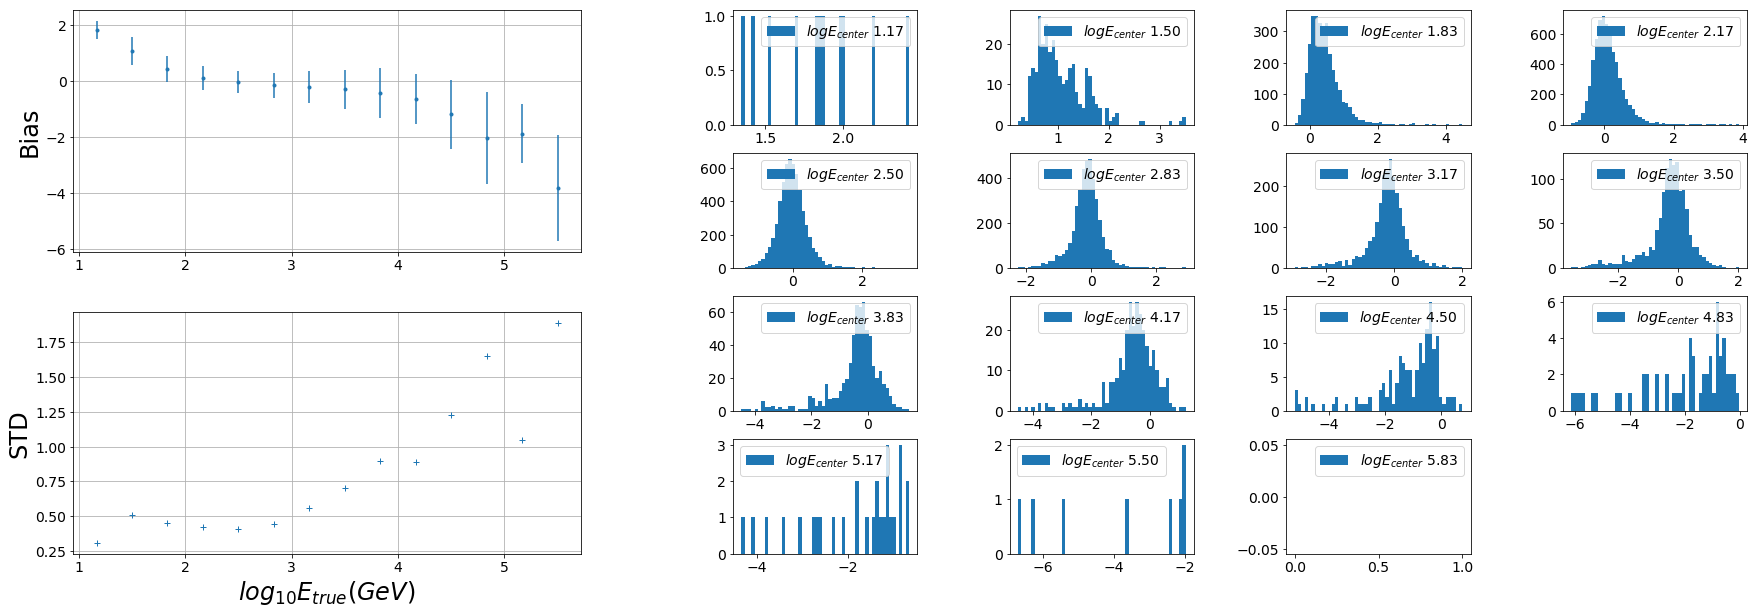

In [30]:
plot_e_resolution(test,15)

<font size="4">
    Now, lets do the cuts on impact parameter to have closer events.

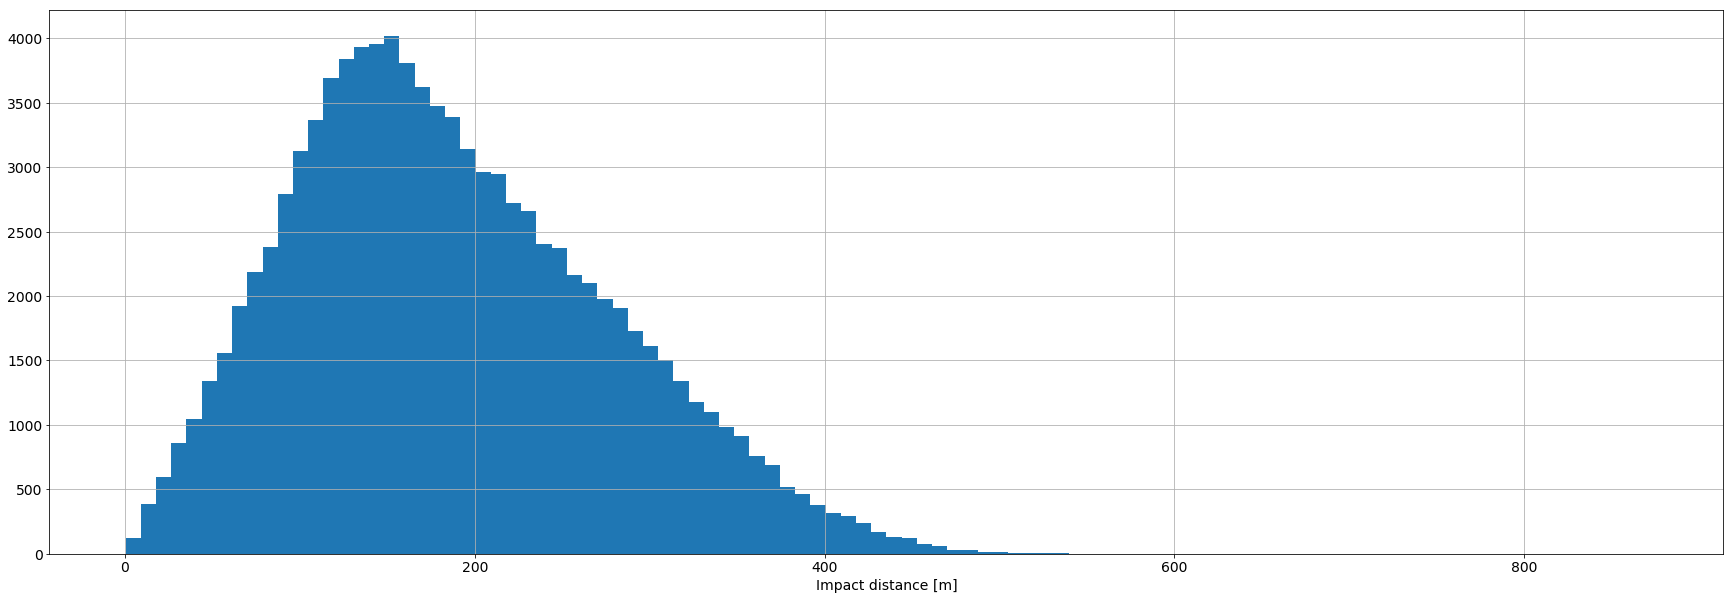

In [31]:
train.mc_core_distance.hist(bins=100);
plt.xlabel('Impact distance [m]');

In [32]:
train_cut = train[(train.mc_core_distance>40) & (train.mc_core_distance<200)]
test_cut = test[(test.mc_core_distance>40) & (test.mc_core_distance<200)]

<font size="4">
    Train the RF again.

In [33]:
RFreg_Energy, RFreg_Disp = reco_dl1_to_dl2.trainRFreco(train_cut, features)

Given features:  ['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi', 'skewness', 'kurtosis']
Number of events for training:  55845
Training Random Forest Regressor for Energy Reconstruction...
Random Forest trained!
Training Random Forest Regressor for disp_norm Reconstruction...
Random Forest trained!
Done!


Feature importances (gini index)
1. intensity (0.945725)
2. time_gradient (0.019341)
3. skewness (0.011258)
4. psi (0.005478)
5. length (0.004334)
6. width (0.003732)
7. phi (0.003523)
8. wl (0.003447)
9. kurtosis (0.003161)


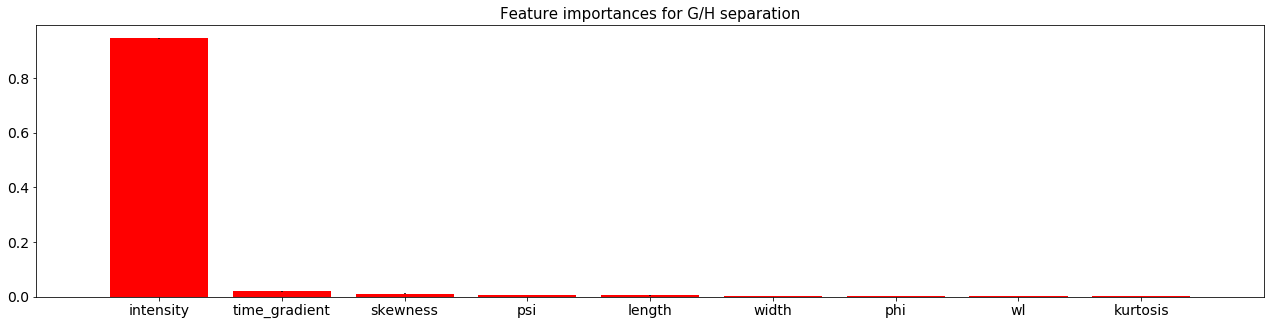

In [34]:
from lstchain.visualization.plot_dl2 import plot_importances
plt.figure(figsize=(22,5))
plot_importances(RFreg_Energy, features);

<font size="4">
    And reconstruct the energy.

In [35]:
test_cut['e_rec'] = RFreg_Energy.predict(test_cut[features])

/home/queenmab/anaconda3/envs/cta-dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.0020895998169574077 0.35558182257793786
32 99.99669054312746 99.33285404651429
0.0020895998169574077 0.3262125379455627


(0.0020895998169574077, 0.3262125379455627)

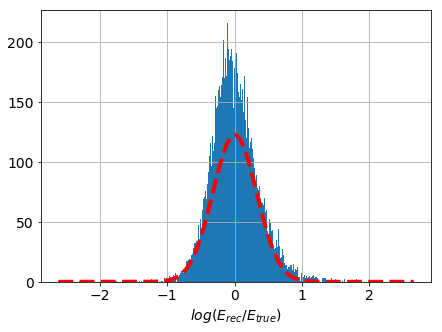

In [36]:
plt.figure(figsize=(7,5))
plt.grid()
#plot_dl2.plot_e(test_cut,True)
calc_resolution(test_cut)

/home/queenmab/anaconda3/envs/cta-dev/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


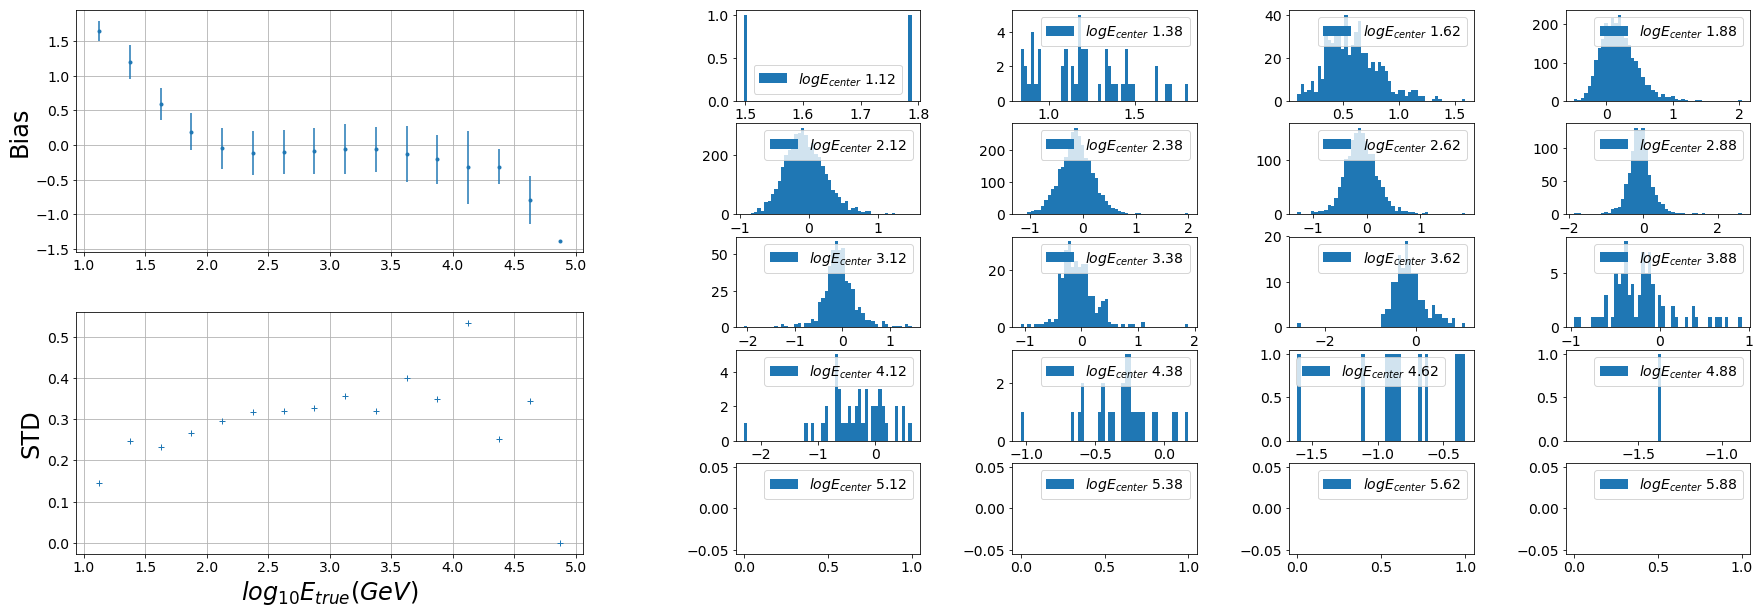

In [37]:
plot_e_resolution(test_cut,20)

<font size="4">
    Let's do a last test. We will use all events, but using the impact parameter as a feature.

In [38]:
features = ['intensity',                                                                                  
            'time_gradient',                                                                              
            'width',                                                                                      
            'length',                                                                                     
            'wl',                                                                                         
            'phi',                                                                                        
            'psi',
            'skewness',
            'kurtosis',
            'mc_core_distance']

<font size="4">
And train Random Forests for Energy and Disp reconstruction.

In [39]:
RFreg_Energy, RFreg_Disp = reco_dl1_to_dl2.trainRFreco(train,features)

Given features:  ['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi', 'skewness', 'kurtosis', 'mc_core_distance']
Number of events for training:  97448
Training Random Forest Regressor for Energy Reconstruction...
Random Forest trained!
Training Random Forest Regressor for disp_norm Reconstruction...
Random Forest trained!
Done!


Feature importances (gini index)
1. intensity (0.497647)
2. mc_core_distance (0.434124)
3. skewness (0.030417)
4. wl (0.013744)
5. length (0.012531)
6. phi (0.006557)
7. psi (0.002742)
8. kurtosis (0.001316)
9. width (0.000510)
10. time_gradient (0.000412)


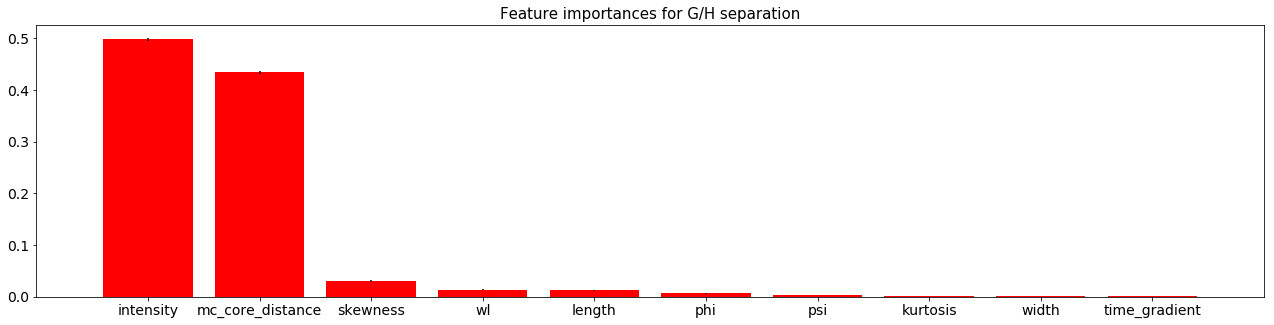

In [40]:
from lstchain.visualization.plot_dl2 import plot_importances
plt.figure(figsize=(22,5))
plot_importances(RFreg_Energy, features);

<font size="4">
Apply RF to test data to reconstruct Energy.

/home/queenmab/anaconda3/envs/cta-dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.0017600177230190932 0.33807383252362705
15 329.2394256720279 321.3665451326256
0.0017600177230190932 0.27359841663871


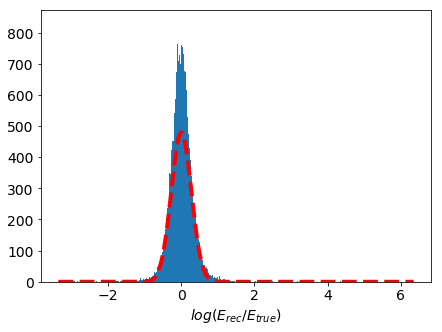

In [41]:
test['e_rec'] = RFreg_Energy.predict(test[features])
plt.figure(figsize=(7,5))
#plot_dl2.plot_e(test,True)
calc_resolution(test)
plt.savefig("gaussian_fit.png")

/home/queenmab/anaconda3/envs/cta-dev/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


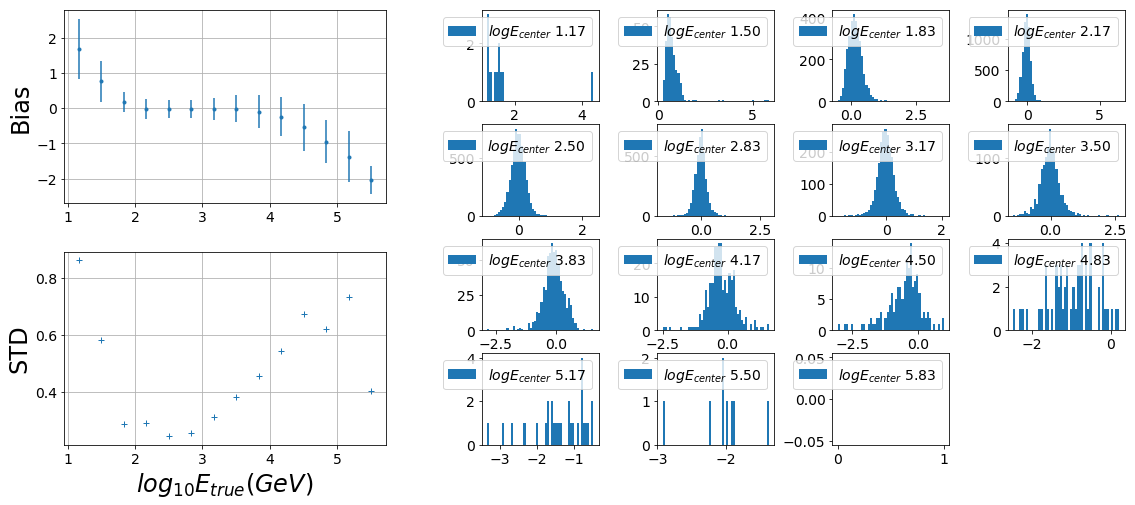

In [42]:
plt.figure(figsize=(19,8))
plot_e_resolution(test,15)